In [385]:
from IPython.display import display
from ngsolve import *
from ngsolve.webgui import Draw
from netgen.csg import *
import netgen.gui

In [386]:
mesh = Mesh(unit_square.GenerateMesh(maxh=0.1))
mesh.nv, mesh.ne   # number of vertices & elements

 Face 1 / 1 (parameter space projection)


(134, 226)

In [387]:
order = 1
fes_curl = HCurl(mesh, order=order, type1=True)  # For 1-forms, H(curl)
fes_H1 = H1(mesh, order=order)     # For 0-forms, H1 space

prodSpc = fes_curl * fes_H1

# Trial and test functions for product space (HCurl and HDiv components)
omega_HCurl, sigma_H1 = prodSpc.TrialFunction()
eta_HCurl, tau_H1 = prodSpc.TestFunction()

One of the most important concepts for the Thesis, the De'Rahm complex:

(also the concept I need to look up all the time when coding NGSolve for the thesis..)

$$

0 \longrightarrow H\Lambda^0(\Omega) \xrightarrow{d} H\Lambda^1(\Omega) \xrightarrow{d} \dots \xrightarrow{d} H\Lambda^n(\Omega) \longrightarrow 0

$$

$$

0 \longrightarrow H^1(\Omega) \xrightarrow{\text{grad}} H(\text{curl}, \Omega) \xrightarrow{\text{curl}} H(\text{div}, \Omega) \xrightarrow{\text{div}} L^2(\Omega) \longrightarrow 0

$$

- $H^1(\Omega)$ are 0-forms or scalars
- $H(\text{curl}, \Omega)$ are 1-forms or vectorfiels
- $H(\text{div}, \Omega)$ are covector-valued 2-forms
  - Camilos maybe wrong interpretation of "covector-valued 2-forms in 2D":
  - flux-density on infinitesimal patches in a subset of $\mathbb{R}^2$

In [388]:
# 3. Bilinear forms for H1 and HCurl spaces - Equation (3a)

# H1 part (0-forms)
a = BilinearForm(prodSpc)
a += sigma_H1 * tau_H1 * dx

#HCurl part (1-forms)
a += - omega_HCurl * grad(tau_H1) * dx 

In [389]:
# 4. Easy part for equation (3b), the inner products without the boundary parts
a +=  grad(sigma_H1) * eta_HCurl * dx
a +=  curl(omega_HCurl) * curl(eta_HCurl) * dx

Hard part for (3b): The boundary terms, the first one being:

$$
.. + \int_{\partial \Omega} \text{tr}(\star d\omega_h) \wedge \text{tr}(\eta_h) 
$$

- $\omega$ and $\eta$ are both 1-forms
- $ \text{tr}(\star d\omega_h) $ 
- Exterior Derivative of $\omega$ is the curl, transforms 1-form $\omega$ to a 2-form.
- Hodge Star operator $\star$ transforms 2-form $\omega$ to a n-k or here a 0-form.
- The wedge product $\wedge$ of a 0-form (curl of $\omega$) and the trace of a 1-form 
  $\text{tr}(\eta)$ is simply a multiplication of a scalar by a tangential component.

WT: does Trace() give the tangential part or n times the tangential part?
valu that shozuld appear (n x curl(u)) * tangentialpart of v
can be rewritten -> curl(u) * ( v_tan x n)
2 ways: 1. .Trace() but make sure one knows what .Trace() does, whats the result? WT not entirely sure
2. just write what you see in n x curl(u) * v

In [390]:
t = specialcf.tangential(mesh.dim)
n = specialcf.normal(mesh.dim)

#a += curl(omega_HCurl) * eta_HCurl.Trace() * t * ds(skeleton=True, definedon = geo.Boundaries('default'))
tr_hs_d_omega = CF(omega_HCurl[1].Diff(x) - omega_HCurl[0].Diff(y))
tr_eta = CF(eta_HCurl[1]*n[0] - eta_HCurl[0]*n[1])

a += tr_hs_d_omega * tr_eta * ds

$$
.. + \int_{\partial \Omega} \text{tr} ( \omega_h ) \wedge \text{tr} ( \star d\eta_h )
$$
We want to arrive at the correct computation of the terms in the boundary integral.
We'll do the computations step by step to have a look at whats going on inside the Integral!

$$
\omega , \eta \in \Lambda^1(\Omega) \, \Longleftrightarrow \, \omega, \eta \in H(\text{curl}, \Omega)
$$

$$
\text{d} \omega \in \Lambda^2(\omega) \, \Longleftrightarrow \, \text{curl}(\omega) \in H(\text{div} , \Omega)
$$

In [391]:
# Turns out the hard part was the "skeleton=True" part lol, now this SHOULD be easy.
# Again wrong, turns out the Hard part was to find the equivalent vector calculus expressions to the differential forms expressions
#a += omega_HCurl.Trace() * t * curl(eta_HCurl) * ds(skeleton=True, definedon = geo.Boundaries('default'))

tr_omega = CF(omega_HCurl[1]*n[0] - omega_HCurl[0]*n[1])
tr_hs_d_eta = CF(eta_HCurl[1].Diff(x) - eta_HCurl[0].Diff(y))

a += tr_omega * tr_hs_d_eta * ds


$$
.. + \frac{C_w}{h} \langle \text{tr}\, \omega, \text{tr}\, \eta \rangle_{\partial \Omega}
$$

In [392]:
# Define constant C_w (set the appropriate value for your problem)
C_w = 1000  # starting value, adjust as needed
h_min = min(Integrate(1, mesh, BND, element_wise=True))
print(h_min)

# Define the bilinear form for this boundary term
#penaltyTerm = BilinearForm(prodSpc)


# Boundary integral for the stabilization/penalty term
a += (C_w / h_min) * omega_HCurl.Trace() * eta_HCurl.Trace() * ds


0.09999999999999959


manufactured solution?? lets try..
- This is the same solution Jay used in the vector laplacian publication
- I think they used this one because it vanishes on the boundary of the unit square
- which is very good  because I dont really get how to incorporate non-zero manufactured solutions in all the boundary terms.    


$$
\omega_{\text{exact}} = \begin{pmatrix} \sin(\pi x) \sin(\pi y) \\ \sin(\pi x) \sin(\pi y) \end{pmatrix}
$$

Need Hodge Laplace for it as well. first term of it:
- Exterior Coderivative of a 1-form in 2D: Divergence -> get a 0-form
- Taking the Exterior Derivative of a 0-form is equivalent to taking the gradient

Second Term:
- Exterior Derivative for 1-forms in 2D: Curl -> get a 2-form
- Taking the Exterior Coderivative of this 2-form formally gives a 1-form..
- Psuedovector operation <-> convention of plus and minus??

$$
\Delta_{\text{H}}\omega = (d \delta \omega + \delta d \omega) = \text{curl}(\text{rot}(\omega)) - \text{grad}(\text{div}(\omega)) = \text{f}
$$

Let's try to build the right hand sind with this manufactured solution!

WT: "if you program it smartly you only have to code 2 version bcs the dim wont matter!"

In [393]:
omega_exact = CF( (sin(pi*x)*sin(pi*y), sin(pi*x)*sin(pi*y)))
delta_omega = -omega_exact[0].Diff(x)-omega_exact[1].Diff(y)
d_delta_omega = CF((delta_omega.Diff(x), delta_omega.Diff(y)))

# Compute the exterior derivative -> curl rot (omega) in 2D
d_omega = CF(omega_exact[1].Diff(x) - omega_exact[0].Diff(y))
#delta_d_omega_x = d_omega.Diff(y)
#delta_d_omega_y = - d_omega.Diff(x)
delta_d_omega = CF((d_omega.Diff(y), - d_omega.Diff(x)))
#delta_d_omega = CF((0, 0))

f_rhs = delta_d_omega + d_delta_omega
f = LinearForm(prodSpc)
f += f_rhs * eta_HCurl * dx

a.Assemble()
f.Assemble()


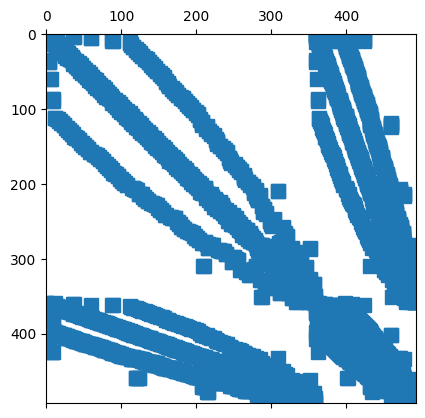

Matrix dimensions: 493 x 493
127971334.2750195
(127971291.2595121+0j)


In [414]:
import matplotlib.pyplot as plt
import scipy.sparse as sp
import numpy as np

from scipy.sparse.linalg import svds
from scipy.sparse import csr_matrix

rows,cols,vals = a.mat.COO()
A = sp.csr_matrix((vals,(rows,cols)))
plt.spy(A)
plt.show()

print("Matrix dimensions:", a.mat.height, "x", a.mat.width)
cond_nr = np.linalg.cond(A.todense())
eigVals = np.linalg.eigvals(A.todense())

print(cond_nr)
print(max(eigVals)/min(eigVals))


In [395]:
sol = GridFunction(prodSpc)
res = f.vec-a.mat * sol.vec
inv = a.mat.Inverse(freedofs=prodSpc.FreeDofs(), inverse="pardiso")
sol.vec.data += inv * res
print(Norm(res))

6.907774461426252e-14


In [396]:
gf_omega , gf_sigma = sol.components

print("L2 Error:", sqrt(Integrate((gf_omega - omega_exact)**2, mesh)))
#print(gf_omega.vec)
Draw(gf_omega)

L2 Error: 0.07104362331354924


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

BaseWebGuiScene